# Exercises - GEO4902-01 - General modeling concepts

[Save google-collab as jupyter notebook, with your name in the filename, and upload on canvas]

# Exercise 01A - How to access the latest weather forecast:

In [1]:
# import python packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy as cy
from matplotlib.dates import DateFormatter
import netCDF4

##### Specify the file on the thredds server. For example the full file of latest forecast of the AROME Arctic weather model. Note, at this point only metadata is retrieved

In [2]:
url='https://thredds.met.no/thredds/dodsC/aromearcticlatest/latest/arome_arctic_lagged_12_h_latest_2_5km_latest.nc'
dataset = xr.open_dataset(url, engine='netcdf4')

### Metadata

In [3]:
dataset

<xarray.Dataset>
Dimensions:                    (time: 58, ensemble_member: 4, pressure: 2,
                                height_above_msl: 1, height0: 1, height1: 1,
                                height2: 1, x: 739, y: 949)
Coordinates:
  * time                       (time) datetime64[ns] 2023-08-30T09:00:00 ... ...
  * ensemble_member            (ensemble_member) int16 0 1 2 3
  * pressure                   (pressure) float32 850.0 925.0
  * height_above_msl           (height_above_msl) float32 0.0
  * height0                    (height0) float32 2.0
  * height1                    (height1) float32 0.0
  * height2                    (height2) float32 10.0
  * x                          (x) float32 2.786e+05 2.811e+05 ... 2.124e+06
  * y                          (y) float32 -8.98e+05 -8.955e+05 ... 1.472e+06
    longitude                  (y, x) float64 ...
    latitude                   (y, x) float64 ...
Data variables: (12/15)
    forecast_reference_time    datetime64[ns] ...
    projection_lambert         int32 ...
    x_wind_pl                  (time, pressure, ensemble_member, y, x) float32 ...
    y_wind_pl                  (time, pressure, ensemble_member, y, x) float32 ...
    air_temperature_pl         (time, pressure, ensemble_member, y, x) float32 ...
    air_temperature_2m         (time, height0, ensemble_member, y, x) float32 ...
    ...                         ...
    cloud_area_fraction        (time, height1, ensemble_member, y, x) float32 ...
    air_pressure_at_sea_level  (time, height_above_msl, ensemble_member, y, x) float32 ...
    precipitation_amount_acc   (time, height1, ensemble_member, y, x) float32 ...
    snowfall_amount_acc        (time, height1, ensemble_member, y, x) float32 ...
    wind_speed_of_gust         (time, height2, ensemble_member, y, x) float32 ...
    fog_area_fraction          (time, height1, ensemble_member, y, x) float32 ...
Attributes: (12/23)
    Conventions:                     CF-1.6, ACDD
    institution:                     Norwegian Meteorological Institute, MET ...
    institution_short_name:          NO/MET
    creator_url:                     met.no
    source:                          AROME-Arctic 2.5km
    title:                           AROME_Arctic 2.5km
    ...                              ...
    dataset_production_status:       Active
    iso_topic_category:              climatologyMeteorologyAtmosphere
    spatial_representation:          grid
    naming_authority:                no.met
    history:                         2023-08-30T11:33:12 creation by fimex
    DODS_EXTRA.Unlimited_Dimension:  time

### Find a specific point and plot the forecast. 
###### Note AROME Arctic is on an irregular grid, so the xarray.sel functionality does not work:

In [4]:
# Function to find a specific lat/lon location 

import math
import numpy as np

def findindex(alat,alon,plat,plon):
    #finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslon,abslat)
    x, y = np.where(c == np.min(c))
    #print(alats[x,y],alon[x,y])
    x=int(x)
    y=int(y)
   
    return (x,y)

In [5]:
#Find a specific location, for example for Longyearbyen

lon = 15.46; lat= 78.24
[xloc,yloc] = findindex(dataset.latitude,dataset.longitude,lon,lat) 

t2m_point = dataset.air_temperature_2m[:,0,1,xloc,yloc]

#Note the number of dimentsions of the temperature array and cross-check with the metadata

/tmp/ipykernel_8534/4292047029.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x=int(x)
/tmp/ipykernel_8534/4292047029.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y=int(y)


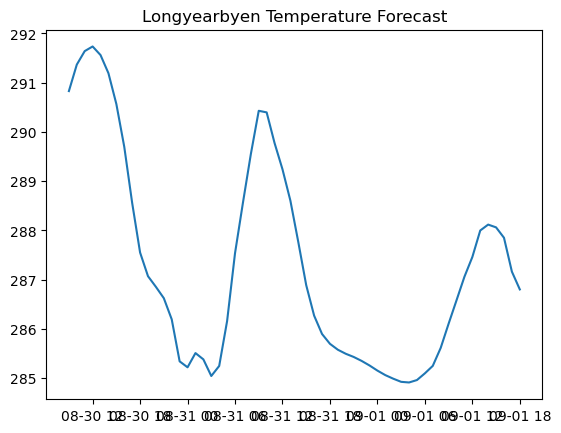

In [6]:
from matplotlib import pyplot as plt

plt.plot(dataset.time, t2m_point, '-')

plt.title("Longyearbyen Temperature Forecast")
plt.show()

### Plot one forecast on a map

#### Choose ensemble member and timestep 

In [7]:
ensemble_mem = 1
timestep = 2

t2m_area = dataset.air_temperature_2m[timestep,0,ensemble_mem,:,:]

Text(0.5, 0.98, 'Temperature forecast')

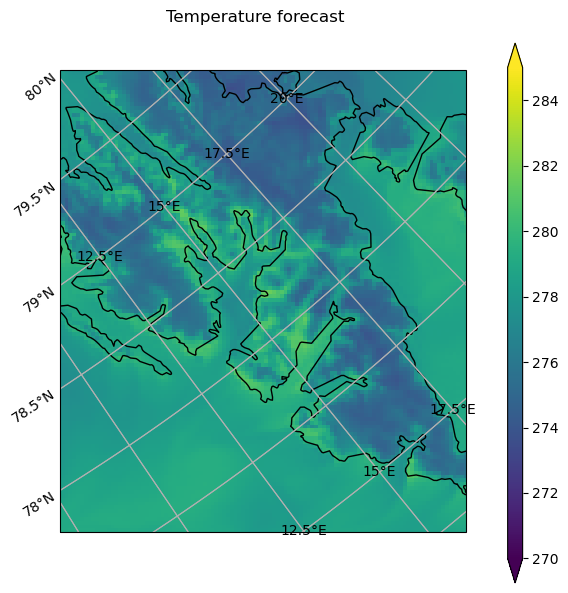

In [8]:
projection = cy.crs.LambertConformal(central_longitude =dataset.projection_lambert.longitude_of_central_meridian,
                                       central_latitude  =dataset.projection_lambert.latitude_of_projection_origin,
                                       standard_parallels = dataset.projection_lambert.standard_parallel)
fig = plt.figure(figsize=[6, 6])

ax = plt.subplot(1, 1, 1, projection=projection)
ax.set_extent([lon - 1.5, lon + 1.5, lat-1.5, lat+1.5], cy.crs.PlateCarree())

ax.gridlines()
ax.add_feature(cy.feature.COASTLINE, zorder=2) 
cf = ax.pcolormesh(t2m_area.longitude,t2m_area.latitude,t2m_area[:,:],transform=cy.crs.PlateCarree(), zorder=1)
cf.set_clim(270,285)
gl = ax.gridlines(draw_labels=True)
gl.top_labels   = False
gl.right_labels = False
   
cbaxes = fig.add_axes([0.92, 0.025, 0.025, 0.9])
cbar = plt.colorbar(cf, cax=cbaxes, shrink=0.5, orientation='vertical', extend='both')

fig.suptitle('Temperature forecast')

In [9]:
from platform import python_version
#import nc_time_axis
import zarr 
import xarray as xr
import matplotlib as mpl
import cftime
import dask as da
import cmcrameri as cm
import scipy
import intake
import seaborn
#import xesmf
import cartopy as crs
import netCDF4

print('python: version {}'.format(python_version()))
#print('nc_time_axis: version {}'.format(nc_time_axis.__version__))
print('zarr: version {}'.format(zarr.__version__))
print('xarray: version {}'.format(xr.__version__))
print('matplotlib: version {}'.format(mpl.__version__))
print('cftime: version {}'.format(cftime.__version__))
print('dask: version {}'.format(da.__version__))
print('cmcrameri: version {}'.format(cm.__version__))
print('scipy: version {}'.format(scipy.__version__))
print('intake: version {}'.format(intake.__version__))
print('seaborn: version {}'.format(seaborn.__version__))
#print('xesmf: version {}'.format(xesmf.__version__))
print('cartopy: version {}'.format(crs.__version__))
print('netCDF4: version {}'.format(netCDF4.__version__))

python: version 3.11.4
zarr: version 2.16.0
xarray: version 2023.6.0
matplotlib: version 3.7.1
cftime: version 1.6.2
dask: version 2023.8.0
cmcrameri: version 1.7
scipy: version 1.11.1
intake: version 0.7.0
seaborn: version 0.12.2
cartopy: version 0.21.1
netCDF4: version 1.6.4
